# Data Attack type classifier

#### Resume

**Objective:** Develop a data classifier that takes into acount CelebA data attack types classification - [CelebA Paper](https://ar5iv.labs.arxiv.org/html/2007.12342?utm_source=chatgpt.com)

CelebA dataset classifies attack types into two categories (Level A1, and Level A2):
*   A1 - Print
  *   A2 - Photo
  *   A2 - Poster
  *   A2 - A4
*   A1 - Paper Cut
  *   A2 - Face Mask
  *   A2 - Upper Body Mask
  *   A2 - Region Mask
*   A1 - Replay
  *   A2 - PC
  *   A2 - Pad
  *   A2 - Phone
*   A1 - 3D
  *   A2 - Mask

To make it easier on the first trained model and POC version, we will focus on just classifing data considering the A1 level of data.
Data interpolation:

1.   Live data: taged with [0] on 40th data input on .csv
2.   A1 - Print attack: taged with [1,2,3] on the data input on .csv
3.   A1 - Paper cut attack: taged with [4,5,6] on the data input on .csv
4.   A1 - Replay attack: taged with [7,8,9] on the data input on .csv
5.   A1 - 3D attack: taged with [10] on the data input on .csv


### Data Loader

Keras tensorflow -> read from csv(json)
*  Partition data based on file folder (Data/test/4931/spoof)

In [ ]:
! pip install pandas tensorflow matplotlib numpy scikit-learn mlxtend

In [79]:
import os
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
#modelos selecionado para 2nd experimento
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.applications import MobileNetV3Small
#para early stopping
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
#para metricas
from sklearn.metrics import precision_score, recall_score, f1_score, roc_curve, roc_auc_score, confusion_matrix, classification_report
from mlxtend.plotting import plot_confusion_matrix
from tensorflow.keras.callbacks import ReduceLROnPlateau

In [81]:
HEIGHT = 224
WIDTH = 224
BATCH_SIZE = 64

In [82]:
path_ = '/home/fmanzoni-lx/Documents/Compal/CelebA-union-downsample/'
trainPath = path_ + 'train/'
testPath = path_ + 'test/'

In [83]:
traindgen = ImageDataGenerator(
                rotation_range=20,
                zoom_range=0.15,
                width_shift_range=0.2,
                height_shift_range=0.2,
                shear_range=0.15,
                horizontal_flip=True,
                rescale=1. / 255,
                fill_mode="nearest",
                validation_split = 0.1
            )
testdgen = ImageDataGenerator(rescale=1. / 255)

In [84]:
class_mode='categorical'
traingen = traindgen.flow_from_directory(
                trainPath,
                target_size=(HEIGHT, WIDTH),
                batch_size=BATCH_SIZE,
                class_mode=class_mode,
                shuffle=True,
                seed=1337,
                subset='training'
            )
valgen = traindgen.flow_from_directory(
                trainPath,
                target_size=(HEIGHT, WIDTH),
                batch_size=BATCH_SIZE,
                class_mode=class_mode,
                shuffle=False,
                subset='validation'
            )
testgen = testdgen.flow_from_directory(
                testPath,
                target_size=(HEIGHT, WIDTH),
                batch_size=BATCH_SIZE,
                class_mode=class_mode,
                shuffle=False
            )

Found 28900 images belonging to 3 classes.
Found 3210 images belonging to 3 classes.
Found 3566 images belonging to 3 classes.


In [85]:
#modelo com VGG16
base_model = VGG16(input_shape=(224,224,3), weights='imagenet', include_top=False)
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(1024, activation='relu')(x)
output = Dense(len(valgen.class_indices), activation='softmax')(x)
model = Model(inputs=[base_model.input], outputs=[output])
model.summary()

Model: "functional_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_12 (InputLayer)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_12     │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 1024)           │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 3)              │         3,075 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,243,075 (58.15 MB)

 Trainable params: 15,243,075 (58.15 MB)

 Non-trainable params: 0 (0.00 B)

In [86]:
#modelo com ResNet50V2
base_model2 = ResNet50V2(input_shape=(224,224,3), weights='imagenet', include_top=False)
x = GlobalAveragePooling2D()(base_model2.output)
x = Dense(1024, activation='relu')(x)
output = Dense(len(valgen.class_indices), activation='softmax')(x)
model2 = Model(inputs=[base_model2.input], outputs=[output])
model2.summary()

Model: "functional_13"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_13      │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_13[0… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_conv[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_preac… │ (None, 56, 56,    │        256 │ pool1_pool[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_preac… │ (None, 56, 56,    │          0 │ conv2_block1_pre… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,096 │ conv2_block1_pre… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_pad  │ (None, 58, 58,    │          0 │ conv2_block1_1_r… │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,864 │ conv2_block1_2_p… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_pre… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_out    │ (None, 56, 56,    │          0 │ conv2_block1_0_c

 Total params: 25,666,051 (97.91 MB)

 Trainable params: 25,620,611 (97.73 MB)

 Non-trainable params: 45,440 (177.50 KB)

In [87]:
base_model3 = MobileNetV3Small(
                input_shape=(224, 224, 3),
                weights='imagenet',
                include_top=False
            )

x = GlobalAveragePooling2D()(base_model3.output)
x = Dense(1024, activation='relu')(x)
output = Dense(len(valgen.class_indices), activation='softmax')(x)

model3 = Model(inputs=[base_model3.input], outputs=[output])

model3.summary()

Model: "functional_14"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_14      │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_4         │ (None, 224, 224,  │          0 │ input_layer_14[0… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv (Conv2D)       │ (None, 112, 112,  │        432 │ rescaling_4[0][0] │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_bn             │ (None, 112, 112,  │         64 │ conv[0][0]        │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_72       │ (None, 112, 112,  │          0 │ conv_bn[0][0]     │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 113, 113,  │          0 │ activation_72[0]… │
│ (ZeroPadding2D)     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 56, 56,    │        144 │ expanded_conv_de… │
│ (DepthwiseConv2D)   │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 56, 56,    │         64 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_56 (ReLU)     │ (None, 56, 56,    │          0 │ expanded_conv_de… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_sque… │ (None, 1, 1, 16)  │          0 │ re_lu_56[0][0]    │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_sque… │ (None, 1, 1, 8)   │        136 │ expanded_conv_sq… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_sque… │ (None, 1, 1, 8)   │          0 │ expanded_conv_sq… │
│ (ReLU)              │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_sque… │ (None, 1, 1, 16)  │        144 │ expanded_conv_sq… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_36 (Add)        │ (None, 1, 1, 16)  │          0 │ expanded_conv_sq… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_57 (ReLU)     │ (None, 1, 1, 16)  │          0 │ add_36[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_36         │ (None, 1, 1, 16)  │          0 │ re_lu_57[0][0]    │
│ (Multiply)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_sque… │ (None, 56, 56,    │          0 │ re_lu_56[0][0],   │
│ (Multiply)          │ 16)               │            │ multiply_36[0][0] │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 1,533,043 (5.85 MB)

 Trainable params: 1,520,931 (5.80 MB)

 Non-trainable params: 12,112 (47.31 KB)

In [88]:
cutoffvgg = len( model.layers)-7
i = 0
for layer in model.layers:
  layer.trainable = i>=cutoffvgg
  i+=1

cutoffrn = len( model2.layers)-16
i = 0
for layer in model2.layers:
  layer.trainable = i>=cutoffrn
  i+=1

cutoffmbn = len( model3.layers)-16
i = 0
for layer in model3.layers:
  layer.trainable = i>=cutoffmbn
  i+=1

In [89]:
for layer in model.layers:
  print( layer, [i.shape for i in layer.weights], layer.trainable)

<InputLayer name=input_layer_12, built=True> [] False
<Conv2D name=block1_conv1, built=True> [TensorShape([3, 3, 3, 64]), TensorShape([64])] False
<Conv2D name=block1_conv2, built=True> [TensorShape([3, 3, 64, 64]), TensorShape([64])] False
<MaxPooling2D name=block1_pool, built=True> [] False
<Conv2D name=block2_conv1, built=True> [TensorShape([3, 3, 64, 128]), TensorShape([128])] False
<Conv2D name=block2_conv2, built=True> [TensorShape([3, 3, 128, 128]), TensorShape([128])] False
<MaxPooling2D name=block2_pool, built=True> [] False
<Conv2D name=block3_conv1, built=True> [TensorShape([3, 3, 128, 256]), TensorShape([256])] False
<Conv2D name=block3_conv2, built=True> [TensorShape([3, 3, 256, 256]), TensorShape([256])] False
<Conv2D name=block3_conv3, built=True> [TensorShape([3, 3, 256, 256]), TensorShape([256])] False
<MaxPooling2D name=block3_pool, built=True> [] False
<Conv2D name=block4_conv1, built=True> [TensorShape([3, 3, 256, 512]), TensorShape([512])] False
<Conv2D name=block4

In [90]:
for layer in model2.layers:
  print( layer, [i.shape for i in layer.weights], layer.trainable)

<InputLayer name=input_layer_13, built=True> [] False
<ZeroPadding2D name=conv1_pad, built=True> [] False
<Conv2D name=conv1_conv, built=True> [TensorShape([7, 7, 3, 64]), TensorShape([64])] False
<ZeroPadding2D name=pool1_pad, built=True> [] False
<MaxPooling2D name=pool1_pool, built=True> [] False
<BatchNormalization name=conv2_block1_preact_bn, built=True> [TensorShape([64]), TensorShape([64]), TensorShape([64]), TensorShape([64])] False
<Activation name=conv2_block1_preact_relu, built=True> [] False
<Conv2D name=conv2_block1_1_conv, built=True> [TensorShape([1, 1, 64, 64])] False
<BatchNormalization name=conv2_block1_1_bn, built=True> [TensorShape([64]), TensorShape([64]), TensorShape([64]), TensorShape([64])] False
<Activation name=conv2_block1_1_relu, built=True> [] False
<ZeroPadding2D name=conv2_block1_2_pad, built=True> [] False
<Conv2D name=conv2_block1_2_conv, built=True> [TensorShape([3, 3, 64, 64])] False
<BatchNormalization name=conv2_block1_2_bn, built=True> [TensorShape

In [91]:
for layer in model3.layers:
  print( layer, [i.shape for i in layer.weights], layer.trainable)

<InputLayer name=input_layer_14, built=True> [] False
<Rescaling name=rescaling_4, built=True> [] False
<Conv2D name=conv, built=True> [TensorShape([3, 3, 3, 16])] False
<BatchNormalization name=conv_bn, built=True> [TensorShape([16]), TensorShape([16]), TensorShape([16]), TensorShape([16])] False
<Activation name=activation_72, built=True> [] False
<ZeroPadding2D name=expanded_conv_depthwise_pad, built=True> [] False
<DepthwiseConv2D name=expanded_conv_depthwise, built=True> [TensorShape([3, 3, 16, 1])] False
<BatchNormalization name=expanded_conv_depthwise_bn, built=True> [TensorShape([16]), TensorShape([16]), TensorShape([16]), TensorShape([16])] False
<ReLU name=re_lu_56, built=True> [] False
<GlobalAveragePooling2D name=expanded_conv_squeeze_excite_avg_pool, built=True> [] False
<Conv2D name=expanded_conv_squeeze_excite_conv, built=True> [TensorShape([1, 1, 16, 8]), TensorShape([8])] False
<ReLU name=expanded_conv_squeeze_excite_relu, built=True> [] False
<Conv2D name=expanded_con

### Treino, Validação e Teste

In [92]:
steps_per_epoch = len(traingen)
validation_steps = len(valgen)
optimizer = keras.optimizers.Adam(learning_rate=1e-4, beta_1=0.85, beta_2=0.999)
loss = 'categorical_crossentropy'
metrics = ['accuracy']
EPOCHS = 200

# Define adaptive LR callback
lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',       # or 'val_accuracy'
    factor=0.1,               # reduce LR by a factor of 0.5
    patience=1,               # after 5 epochs with no improvement
    min_lr=1e-7,              # don't go below this
    verbose=1
)

In [93]:
callbacksA =    [EarlyStopping(monitor='val_loss', mode='min', patience=4, verbose=1, restore_best_weights=True), lr_scheduler,
                 ModelCheckpoint('best_modelA.h5', monitor='val_loss', mode='min', verbose=1, save_best_only=True)]
callbacksB =    [EarlyStopping(monitor='val_loss', mode='min', patience=10, verbose=1, restore_best_weights=True), lr_scheduler,
                 ModelCheckpoint('best_modelB.h5', monitor='val_loss', mode='min', verbose=1, save_best_only=True)]
callbacksC =    [EarlyStopping(monitor='val_loss', mode='min', patience=10, verbose=1, restore_best_weights=True), lr_scheduler,
                 ModelCheckpoint('best_modelC.h5', monitor='val_loss', mode='min', verbose=1, save_best_only=True)]

### VGG16

In [48]:
model.compile(optimizer=optimizer,
              loss=loss,
              metrics=metrics)

In [49]:
results = model.fit(
            x=traingen,
            steps_per_epoch=steps_per_epoch,
            epochs=EPOCHS,
            validation_data=valgen,
            validation_steps=validation_steps,
            callbacks=callbacksA
          )

Epoch 1/200
904/904 ━━━━━━━━━━━━━━━━━━━━ 0s 467ms/step - accuracy: 0.9625 - loss: 0.1027
Epoch 1: val_loss improved from inf to 0.10168, saving model to best_modelA.h5


904/904 ━━━━━━━━━━━━━━━━━━━━ 469s 515ms/step - accuracy: 0.9625 - loss: 0.1027 - val_accuracy: 0.9589 - val_loss: 0.1017 - learning_rate: 1.0000e-04
Epoch 2/200
904/904 ━━━━━━━━━━━━━━━━━━━━ 0s 469ms/step - accuracy: 0.9671 - loss: 0.0874
Epoch 2: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.

Epoch 2: val_loss did not improve from 0.10168
904/904 ━━━━━━━━━━━━━━━━━━━━ 466s 515ms/step - accuracy: 0.9671 - loss: 0.0874 - val_accuracy: 0.9614 - val_loss: 0.1026 - learning_rate: 1.0000e-04
Epoch 3/200
904/904 ━━━━━━━━━━━━━━━━━━━━ 0s 440ms/step - accuracy: 0.9824 - loss: 0.0514
Epoch 3: val_loss improved from 0.10168 to 0.07881, saving model to best_modelA.h5


904/904 ━━━━━━━━━━━━━━━━━━━━ 439s 485ms/step - accuracy: 0.9824 - loss: 0.0514 - val_accuracy: 0.9720 - val_loss: 0.0788 - learning_rate: 1.0000e-05
Epoch 4/200
904/904 ━━━━━━━━━━━━━━━━━━━━ 0s 504ms/step - accuracy: 0.9876 - loss: 0.0371
Epoch 4: val_loss improved from 0.07881 to 0.07580, saving model to best_modelA.h5


904/904 ━━━━━━━━━━━━━━━━━━━━ 509s 563ms/step - accuracy: 0.9876 - loss: 0.0371 - val_accuracy: 0.9717 - val_loss: 0.0758 - learning_rate: 1.0000e-05
Epoch 5/200
904/904 ━━━━━━━━━━━━━━━━━━━━ 0s 549ms/step - accuracy: 0.9877 - loss: 0.0342
Epoch 5: val_loss improved from 0.07580 to 0.07121, saving model to best_modelA.h5


904/904 ━━━━━━━━━━━━━━━━━━━━ 546s 604ms/step - accuracy: 0.9877 - loss: 0.0342 - val_accuracy: 0.9738 - val_loss: 0.0712 - learning_rate: 1.0000e-05
Epoch 6/200
904/904 ━━━━━━━━━━━━━━━━━━━━ 0s 552ms/step - accuracy: 0.9892 - loss: 0.0333
Epoch 6: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-07.

Epoch 6: val_loss did not improve from 0.07121
904/904 ━━━━━━━━━━━━━━━━━━━━ 553s 611ms/step - accuracy: 0.9892 - loss: 0.0333 - val_accuracy: 0.9688 - val_loss: 0.0758 - learning_rate: 1.0000e-05
Epoch 7/200
904/904 ━━━━━━━━━━━━━━━━━━━━ 0s 510ms/step - accuracy: 0.9892 - loss: 0.0310
Epoch 7: ReduceLROnPlateau reducing learning rate to 1e-07.

Epoch 7: val_loss did not improve from 0.07121
904/904 ━━━━━━━━━━━━━━━━━━━━ 502s 555ms/step - accuracy: 0.9892 - loss: 0.0310 - val_accuracy: 0.9735 - val_loss: 0.0727 - learning_rate: 1.0000e-06
Epoch 8/200
904/904 ━━━━━━━━━━━━━━━━━━━━ 0s 440ms/step - accuracy: 0.9902 - loss: 0.0270
Epoch 8: val_loss improved from 0.07121 to 0.06960, sa

904/904 ━━━━━━━━━━━━━━━━━━━━ 438s 485ms/step - accuracy: 0.9902 - loss: 0.0270 - val_accuracy: 0.9735 - val_loss: 0.0696 - learning_rate: 1.0000e-07
Epoch 9/200
904/904 ━━━━━━━━━━━━━━━━━━━━ 0s 425ms/step - accuracy: 0.9899 - loss: 0.0284
Epoch 9: val_loss improved from 0.06960 to 0.06821, saving model to best_modelA.h5


904/904 ━━━━━━━━━━━━━━━━━━━━ 425s 470ms/step - accuracy: 0.9899 - loss: 0.0284 - val_accuracy: 0.9754 - val_loss: 0.0682 - learning_rate: 1.0000e-07
Epoch 10/200
904/904 ━━━━━━━━━━━━━━━━━━━━ 0s 429ms/step - accuracy: 0.9897 - loss: 0.0274
Epoch 10: val_loss improved from 0.06821 to 0.06737, saving model to best_modelA.h5


904/904 ━━━━━━━━━━━━━━━━━━━━ 428s 473ms/step - accuracy: 0.9897 - loss: 0.0274 - val_accuracy: 0.9754 - val_loss: 0.0674 - learning_rate: 1.0000e-07
Epoch 11/200
904/904 ━━━━━━━━━━━━━━━━━━━━ 0s 439ms/step - accuracy: 0.9906 - loss: 0.0274
Epoch 11: val_loss improved from 0.06737 to 0.06365, saving model to best_modelA.h5


904/904 ━━━━━━━━━━━━━━━━━━━━ 436s 482ms/step - accuracy: 0.9906 - loss: 0.0274 - val_accuracy: 0.9763 - val_loss: 0.0636 - learning_rate: 1.0000e-07
Epoch 12/200
904/904 ━━━━━━━━━━━━━━━━━━━━ 0s 478ms/step - accuracy: 0.9911 - loss: 0.0269
Epoch 12: val_loss did not improve from 0.06365
904/904 ━━━━━━━━━━━━━━━━━━━━ 483s 534ms/step - accuracy: 0.9911 - loss: 0.0269 - val_accuracy: 0.9754 - val_loss: 0.0644 - learning_rate: 1.0000e-07
Epoch 13/200
904/904 ━━━━━━━━━━━━━━━━━━━━ 0s 584ms/step - accuracy: 0.9890 - loss: 0.0294
Epoch 13: val_loss did not improve from 0.06365
904/904 ━━━━━━━━━━━━━━━━━━━━ 582s 644ms/step - accuracy: 0.9890 - loss: 0.0294 - val_accuracy: 0.9735 - val_loss: 0.0652 - learning_rate: 1.0000e-07
Epoch 14/200
904/904 ━━━━━━━━━━━━━━━━━━━━ 0s 556ms/step - accuracy: 0.9895 - loss: 0.0283
Epoch 14: val_loss did not improve from 0.06365
904/904 ━━━━━━━━━━━━━━━━━━━━ 550s 608ms/step - accuracy: 0.9895 - loss: 0.0283 - val_accuracy: 0.9751 - val_loss: 0.0644 - learning_rate: 1

#### VGG16 - Trained results

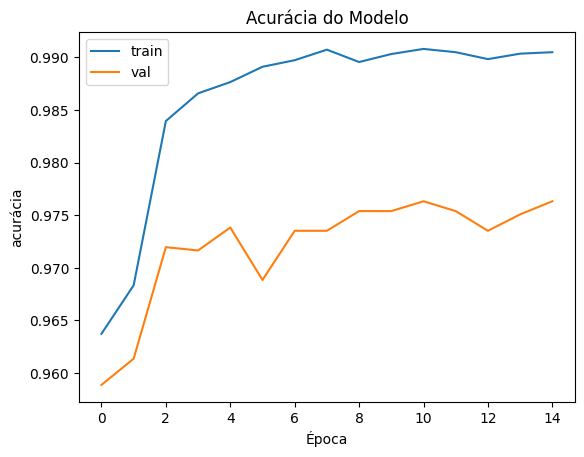

In [50]:
plt.plot(results.history['accuracy'])
plt.plot(results.history['val_accuracy'])
plt.title('Acurácia do Modelo')
plt.ylabel('acurácia')
plt.xlabel('Época')
plt.legend(['train', 'val'])
plt.show()

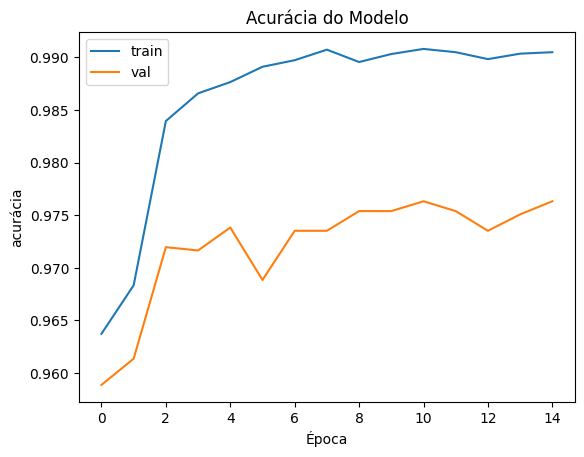

In [51]:
plt.plot(results.history['accuracy'])
plt.plot(results.history['val_accuracy'])
plt.title('Acurácia do Modelo')
plt.ylabel('acurácia')
plt.xlabel('Época')
plt.legend(['train', 'val'])
plt.show()

In [52]:
y_predA = model.predict( x=testgen).argmax(axis=1)
y_trueA = testgen.classes
confmatrixA = confusion_matrix( y_trueA, y_predA)
scoresA = model.evaluate( x=testgen, verbose=1)
print('Erro teste: ', scoresA[0])
print('Acuracia teste: ', scoresA[1])

/home/fmanzoni-lx/.local/lib/python3.10/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_786']
Received: inputs=Tensor(shape=(32, 224, 224, 3))
  warnings.warn(msg)


111/112 ━━━━━━━━━━━━━━━━━━━━ 0s 276ms/step

2025-05-15 12:56:13.555579: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algorithm eng14{k25=2} for conv %cudnn-conv-bias-activation.39 = (f32[14,64,224,224]{3,2,1,0}, u8[0]{0}) custom-call(f32[14,3,224,224]{3,2,1,0} %bitcast.496, f32[64,3,3,3]{3,2,1,0} %bitcast.503, f32[64]{0} %bitcast.505), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", metadata={op_type="Conv2D" op_name="functional_6_1/block1_conv1_1/convolution" source_file="/home/fmanzoni-lx/.local/lib/python3.10/site-packages/tensorflow/python/framework/ops.py" source_line=1200}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kRelu","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false}
2025-05-15 12:56:13.682631: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Om

112/112 ━━━━━━━━━━━━━━━━━━━━ 42s 361ms/step
112/112 ━━━━━━━━━━━━━━━━━━━━ 32s 282ms/step - accuracy: 0.9886 - loss: 0.0356
Erro teste:  0.04550005868077278
Acuracia teste:  0.9873808026313782


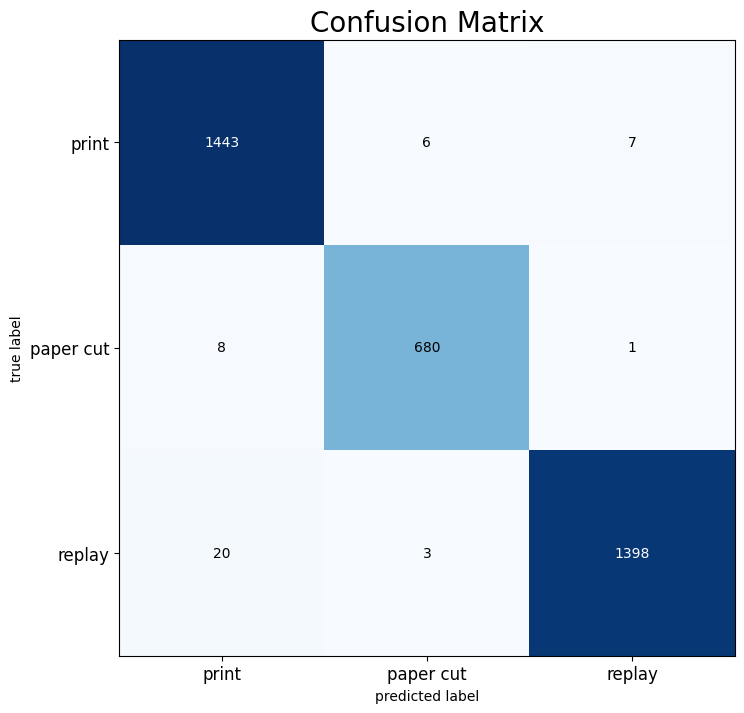



Outras métricas



{'spoof_1_print': 0, 'spoof_2_paper_cut': 1, 'spoof_3_replay': 2}
0
Precision     : 98.10%
Recall        : 99.11%
F1-Score      : 98.60%
1
Precision     : 98.69%
Recall        : 98.69%
F1-Score      : 98.69%
2
Precision     : 99.43%
Recall        : 98.38%
F1-Score      : 98.90%


In [54]:
CM = confusion_matrix(y_trueA, y_predA)
classes =  ['print','paper cut','replay']

fig, ax = plot_confusion_matrix(conf_mat=CM ,  figsize=(10,8), hide_ticks=True,cmap=plt.cm.Blues)
plt.xticks(range(3), classes, fontsize=12)
plt.yticks(range(3), classes, fontsize=12)
plt.title("Confusion Matrix", fontsize=20)
plt.show()


precision = precision_score(y_trueA, y_predA, average=None)
recall = recall_score(y_trueA, y_predA, average=None)
f1 = f1_score(y_trueA, y_predA, average=None)
print("\n")
print("Outras métricas")
print("\n\n")
print(testgen.class_indices)
for i in range(0,3):
    print(i)
    print("%s%.2f%s"% ("Precision     : ", precision[i]*100, "%"))
    print("%s%.2f%s"% ("Recall        : ", recall[i]*100,    "%"))
    print("%s%.2f%s"% ("F1-Score      : ", f1[i]*100,        "%"))

### RESNET50 v2

In [71]:
model2.compile(optimizer=optimizer,#os
              loss=loss,
              metrics=metrics)

In [72]:
resultsB = model2.fit(
              x=traingen,
              steps_per_epoch=steps_per_epoch,
              epochs=EPOCHS,
              validation_data=valgen,
              validation_steps=validation_steps,
              callbacks=callbacksB
            )

/home/fmanzoni-lx/.local/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/200


/home/fmanzoni-lx/.local/lib/python3.10/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_1201']
Received: inputs=Tensor(shape=(None, 224, 224, 3))
  warnings.warn(msg)


904/904 ━━━━━━━━━━━━━━━━━━━━ 0s 481ms/step - accuracy: 0.8189 - loss: 0.4202
Epoch 1: val_loss improved from inf to 0.17989, saving model to best_modelB.h5


904/904 ━━━━━━━━━━━━━━━━━━━━ 509s 543ms/step - accuracy: 0.8190 - loss: 0.4200 - val_accuracy: 0.9277 - val_loss: 0.1799 - learning_rate: 1.0000e-04
Epoch 2/200
904/904 ━━━━━━━━━━━━━━━━━━━━ 0s 439ms/step - accuracy: 0.9411 - loss: 0.1590
Epoch 2: val_loss improved from 0.17989 to 0.13034, saving model to best_modelB.h5


904/904 ━━━━━━━━━━━━━━━━━━━━ 439s 486ms/step - accuracy: 0.9411 - loss: 0.1590 - val_accuracy: 0.9505 - val_loss: 0.1303 - learning_rate: 1.0000e-04
Epoch 3/200
904/904 ━━━━━━━━━━━━━━━━━━━━ 0s 439ms/step - accuracy: 0.9580 - loss: 0.1161
Epoch 3: val_loss improved from 0.13034 to 0.09767, saving model to best_modelB.h5


904/904 ━━━━━━━━━━━━━━━━━━━━ 439s 485ms/step - accuracy: 0.9580 - loss: 0.1161 - val_accuracy: 0.9604 - val_loss: 0.0977 - learning_rate: 1.0000e-04
Epoch 4/200
904/904 ━━━━━━━━━━━━━━━━━━━━ 0s 441ms/step - accuracy: 0.9636 - loss: 0.0993
Epoch 4: val_loss improved from 0.09767 to 0.09749, saving model to best_modelB.h5


904/904 ━━━━━━━━━━━━━━━━━━━━ 441s 488ms/step - accuracy: 0.9636 - loss: 0.0993 - val_accuracy: 0.9636 - val_loss: 0.0975 - learning_rate: 1.0000e-04
Epoch 5/200
904/904 ━━━━━━━━━━━━━━━━━━━━ 0s 442ms/step - accuracy: 0.9698 - loss: 0.0822
Epoch 5: val_loss improved from 0.09749 to 0.08673, saving model to best_modelB.h5


904/904 ━━━━━━━━━━━━━━━━━━━━ 442s 488ms/step - accuracy: 0.9698 - loss: 0.0822 - val_accuracy: 0.9701 - val_loss: 0.0867 - learning_rate: 1.0000e-04
Epoch 6/200
904/904 ━━━━━━━━━━━━━━━━━━━━ 0s 440ms/step - accuracy: 0.9765 - loss: 0.0670
Epoch 6: val_loss improved from 0.08673 to 0.08404, saving model to best_modelB.h5


904/904 ━━━━━━━━━━━━━━━━━━━━ 440s 487ms/step - accuracy: 0.9765 - loss: 0.0670 - val_accuracy: 0.9679 - val_loss: 0.0840 - learning_rate: 1.0000e-04
Epoch 7/200
904/904 ━━━━━━━━━━━━━━━━━━━━ 0s 441ms/step - accuracy: 0.9766 - loss: 0.0660
Epoch 7: val_loss improved from 0.08404 to 0.08293, saving model to best_modelB.h5


904/904 ━━━━━━━━━━━━━━━━━━━━ 441s 488ms/step - accuracy: 0.9766 - loss: 0.0660 - val_accuracy: 0.9688 - val_loss: 0.0829 - learning_rate: 1.0000e-04
Epoch 8/200
904/904 ━━━━━━━━━━━━━━━━━━━━ 0s 441ms/step - accuracy: 0.9788 - loss: 0.0597
Epoch 8: val_loss improved from 0.08293 to 0.06967, saving model to best_modelB.h5


904/904 ━━━━━━━━━━━━━━━━━━━━ 441s 488ms/step - accuracy: 0.9788 - loss: 0.0597 - val_accuracy: 0.9760 - val_loss: 0.0697 - learning_rate: 1.0000e-04
Epoch 9/200
904/904 ━━━━━━━━━━━━━━━━━━━━ 0s 438ms/step - accuracy: 0.9802 - loss: 0.0539
Epoch 9: val_loss improved from 0.06967 to 0.06612, saving model to best_modelB.h5


904/904 ━━━━━━━━━━━━━━━━━━━━ 439s 485ms/step - accuracy: 0.9802 - loss: 0.0539 - val_accuracy: 0.9766 - val_loss: 0.0661 - learning_rate: 1.0000e-04
Epoch 10/200
904/904 ━━━━━━━━━━━━━━━━━━━━ 0s 436ms/step - accuracy: 0.9820 - loss: 0.0484
Epoch 10: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.

Epoch 10: val_loss did not improve from 0.06612
904/904 ━━━━━━━━━━━━━━━━━━━━ 436s 482ms/step - accuracy: 0.9820 - loss: 0.0484 - val_accuracy: 0.9751 - val_loss: 0.0722 - learning_rate: 1.0000e-04
Epoch 11/200
904/904 ━━━━━━━━━━━━━━━━━━━━ 0s 438ms/step - accuracy: 0.9867 - loss: 0.0380
Epoch 11: val_loss improved from 0.06612 to 0.06017, saving model to best_modelB.h5


904/904 ━━━━━━━━━━━━━━━━━━━━ 438s 484ms/step - accuracy: 0.9867 - loss: 0.0380 - val_accuracy: 0.9794 - val_loss: 0.0602 - learning_rate: 1.0000e-05
Epoch 12/200
904/904 ━━━━━━━━━━━━━━━━━━━━ 0s 435ms/step - accuracy: 0.9902 - loss: 0.0291
Epoch 12: val_loss improved from 0.06017 to 0.05384, saving model to best_modelB.h5


904/904 ━━━━━━━━━━━━━━━━━━━━ 436s 482ms/step - accuracy: 0.9902 - loss: 0.0291 - val_accuracy: 0.9801 - val_loss: 0.0538 - learning_rate: 1.0000e-05
Epoch 13/200
904/904 ━━━━━━━━━━━━━━━━━━━━ 0s 436ms/step - accuracy: 0.9906 - loss: 0.0268
Epoch 13: val_loss improved from 0.05384 to 0.04877, saving model to best_modelB.h5


904/904 ━━━━━━━━━━━━━━━━━━━━ 436s 482ms/step - accuracy: 0.9906 - loss: 0.0269 - val_accuracy: 0.9816 - val_loss: 0.0488 - learning_rate: 1.0000e-05
Epoch 14/200
904/904 ━━━━━━━━━━━━━━━━━━━━ 0s 438ms/step - accuracy: 0.9902 - loss: 0.0284
Epoch 14: val_loss improved from 0.04877 to 0.04862, saving model to best_modelB.h5


904/904 ━━━━━━━━━━━━━━━━━━━━ 438s 484ms/step - accuracy: 0.9902 - loss: 0.0284 - val_accuracy: 0.9810 - val_loss: 0.0486 - learning_rate: 1.0000e-05
Epoch 15/200
904/904 ━━━━━━━━━━━━━━━━━━━━ 0s 437ms/step - accuracy: 0.9903 - loss: 0.0271
Epoch 15: val_loss improved from 0.04862 to 0.04833, saving model to best_modelB.h5


904/904 ━━━━━━━━━━━━━━━━━━━━ 437s 484ms/step - accuracy: 0.9903 - loss: 0.0271 - val_accuracy: 0.9844 - val_loss: 0.0483 - learning_rate: 1.0000e-05
Epoch 16/200
904/904 ━━━━━━━━━━━━━━━━━━━━ 0s 437ms/step - accuracy: 0.9917 - loss: 0.0246
Epoch 16: val_loss improved from 0.04833 to 0.04185, saving model to best_modelB.h5


904/904 ━━━━━━━━━━━━━━━━━━━━ 438s 484ms/step - accuracy: 0.9917 - loss: 0.0246 - val_accuracy: 0.9854 - val_loss: 0.0419 - learning_rate: 1.0000e-05
Epoch 17/200
904/904 ━━━━━━━━━━━━━━━━━━━━ 0s 437ms/step - accuracy: 0.9922 - loss: 0.0231
Epoch 17: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-07.

Epoch 17: val_loss did not improve from 0.04185
904/904 ━━━━━━━━━━━━━━━━━━━━ 437s 483ms/step - accuracy: 0.9922 - loss: 0.0231 - val_accuracy: 0.9850 - val_loss: 0.0435 - learning_rate: 1.0000e-05
Epoch 18/200
904/904 ━━━━━━━━━━━━━━━━━━━━ 0s 438ms/step - accuracy: 0.9909 - loss: 0.0225
Epoch 18: ReduceLROnPlateau reducing learning rate to 1e-07.

Epoch 18: val_loss did not improve from 0.04185
904/904 ━━━━━━━━━━━━━━━━━━━━ 437s 483ms/step - accuracy: 0.9909 - loss: 0.0225 - val_accuracy: 0.9850 - val_loss: 0.0471 - learning_rate: 1.0000e-06
Epoch 19/200
904/904 ━━━━━━━━━━━━━━━━━━━━ 0s 444ms/step - accuracy: 0.9914 - loss: 0.0260
Epoch 19: val_loss did not improve from 0.04185

904/904 ━━━━━━━━━━━━━━━━━━━━ 439s 486ms/step - accuracy: 0.9924 - loss: 0.0216 - val_accuracy: 0.9863 - val_loss: 0.0412 - learning_rate: 1.0000e-07
Epoch 21/200
904/904 ━━━━━━━━━━━━━━━━━━━━ 0s 440ms/step - accuracy: 0.9918 - loss: 0.0227
Epoch 21: val_loss did not improve from 0.04123
904/904 ━━━━━━━━━━━━━━━━━━━━ 439s 485ms/step - accuracy: 0.9918 - loss: 0.0227 - val_accuracy: 0.9785 - val_loss: 0.0627 - learning_rate: 1.0000e-07
Epoch 22/200
904/904 ━━━━━━━━━━━━━━━━━━━━ 0s 440ms/step - accuracy: 0.9925 - loss: 0.0209
Epoch 22: val_loss did not improve from 0.04123
904/904 ━━━━━━━━━━━━━━━━━━━━ 440s 487ms/step - accuracy: 0.9925 - loss: 0.0209 - val_accuracy: 0.9829 - val_loss: 0.0573 - learning_rate: 1.0000e-07
Epoch 23/200
904/904 ━━━━━━━━━━━━━━━━━━━━ 0s 458ms/step - accuracy: 0.9925 - loss: 0.0228
Epoch 23: val_loss did not improve from 0.04123
904/904 ━━━━━━━━━━━━━━━━━━━━ 456s 505ms/step - accuracy: 0.9925 - loss: 0.0228 - val_accuracy: 0.9819 - val_loss: 0.0570 - learning_rate: 1

#### Results

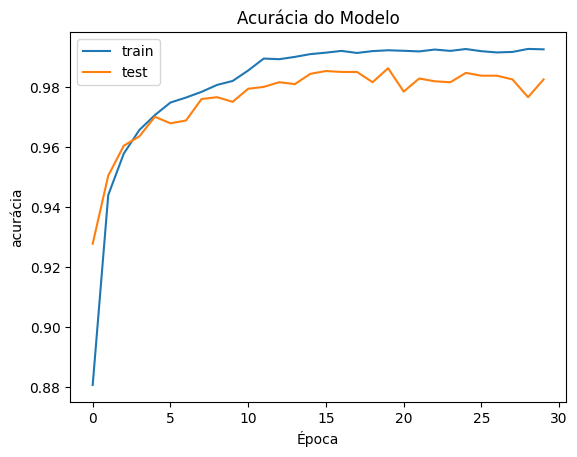

In [73]:
plt.plot(resultsB.history['accuracy'])
plt.plot(resultsB.history['val_accuracy'])
plt.title('Acurácia do Modelo')
plt.ylabel('acurácia')
plt.xlabel('Época')
plt.legend(['train', 'test'])
plt.show()

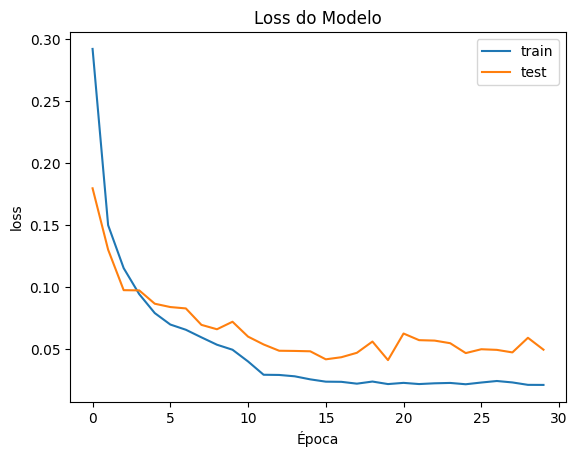

In [74]:
plt.plot(resultsB.history['loss'])
plt.plot(resultsB.history['val_loss'])
plt.title('Loss do Modelo')
plt.ylabel('loss')
plt.xlabel('Época')
plt.legend(['train', 'test'])
plt.show()

In [75]:
y_predB = model2.predict( x=testgen).argmax(axis=1)
y_trueB = testgen.classes
scoresB = model2.evaluate( x=testgen, verbose=1)
print('Erro teste: ', scoresB[0])
print('Acuracia teste: ', scoresB[1])

/home/fmanzoni-lx/.local/lib/python3.10/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_1201']
Received: inputs=Tensor(shape=(32, 224, 224, 3))
  warnings.warn(msg)


112/112 ━━━━━━━━━━━━━━━━━━━━ 28s 209ms/step
112/112 ━━━━━━━━━━━━━━━━━━━━ 17s 148ms/step - accuracy: 0.9903 - loss: 0.0384
Erro teste:  0.04445455223321915
Acuracia teste:  0.9890633821487427


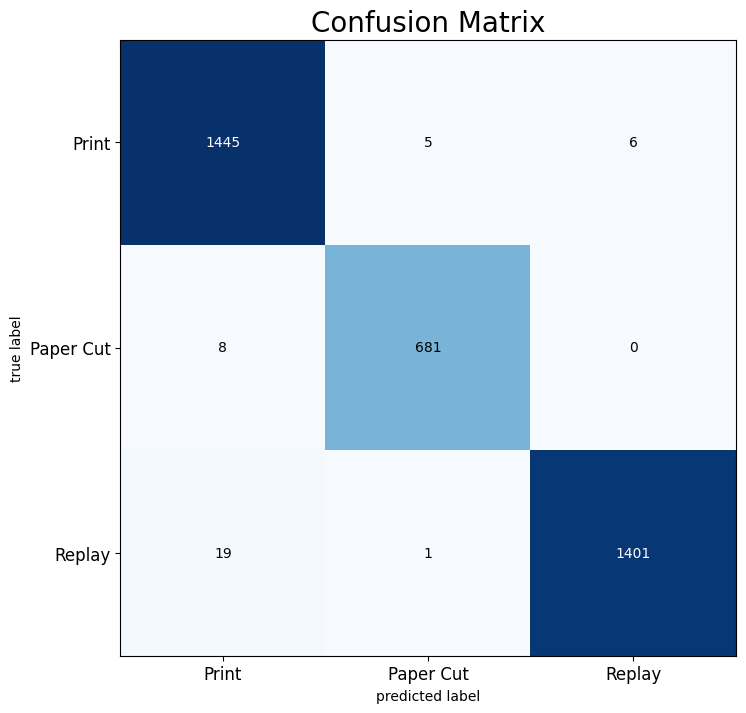



Outras métricas



{'spoof_1_print': 0, 'spoof_2_paper_cut': 1, 'spoof_3_replay': 2}
0
Precision     : 98.17%
Recall        : 99.24%
F1-Score      : 98.70%
1
Precision     : 99.13%
Recall        : 98.84%
F1-Score      : 98.98%
2
Precision     : 99.57%
Recall        : 98.59%
F1-Score      : 99.08%


In [76]:
CM = confusion_matrix(y_trueB, y_predB)
classes =  ['Print','Paper Cut','Replay']

fig, ax = plot_confusion_matrix(conf_mat=CM ,  figsize=(10,8), hide_ticks=True,cmap=plt.cm.Blues)
plt.xticks(range(3), classes, fontsize=12)
plt.yticks(range(3), classes, fontsize=12)
plt.title("Confusion Matrix", fontsize=20)
plt.show()


precision = precision_score(y_trueB, y_predB, average=None)
recall = recall_score(y_trueB, y_predB, average=None)
f1 = f1_score(y_trueB, y_predB, average=None)
print("\n")
print("Outras métricas")
print("\n\n")
print(testgen.class_indices)
for i in range(0,3):
    print(i)
    print("%s%.2f%s"% ("Precision     : ", precision[i]*100, "%"))
    print("%s%.2f%s"% ("Recall        : ", recall[i]*100,    "%"))
    print("%s%.2f%s"% ("F1-Score      : ", f1[i]*100,        "%"))

### Mobile Net V3 Small

In [ ]:
model3.compile(optimizer=optimizer,#os
              loss=loss,
              metrics=metrics)

In [102]:
resultsC = model3.fit(
              x=traingen,
              steps_per_epoch=steps_per_epoch,
              epochs=EPOCHS,
              validation_data=valgen,
              validation_steps=validation_steps,
              callbacks= callbacksC
            )

Epoch 1/200


/home/fmanzoni-lx/.local/lib/python3.10/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_1787']
Received: inputs=Tensor(shape=(None, 224, 224, 3))
  warnings.warn(msg)


KeyboardInterrupt: 

#### Results

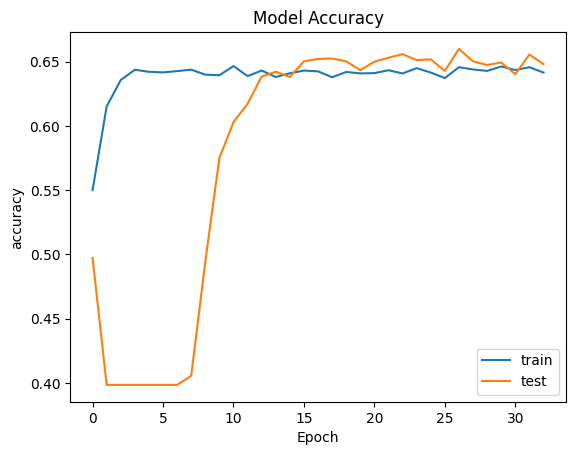

In [ ]:
plt.plot(resultsC.history['accuracy'])
plt.plot(resultsC.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'test'])
plt.show()

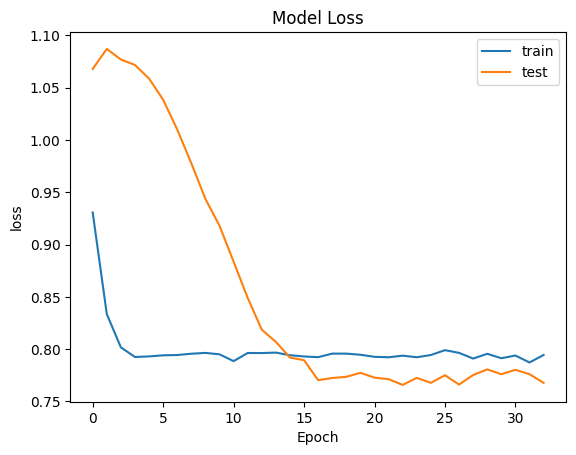

In [ ]:
plt.plot(resultsC.history['loss'])
plt.plot(resultsC.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'])
plt.show()

In [ ]:
y_predC = model3.predict( x=testgen).argmax(axis=1)
y_trueC = testgen.classes
scoresC = model3.evaluate( x=testgen, verbose=1)
print('Test Error: ', scoresC[0])
print('Test Accuracy: ', scoresC[1])

/home/fmanzoni-lx/.local/lib/python3.10/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_1787']
Received: inputs=Tensor(shape=(64, 224, 224, 3))
  warnings.warn(msg)


56/56 ━━━━━━━━━━━━━━━━━━━━ 30s 438ms/step
56/56 ━━━━━━━━━━━━━━━━━━━━ 17s 296ms/step - accuracy: 0.6988 - loss: 0.7230
Test Error:  0.6950769424438477
Test Accuracy:  0.6999439001083374


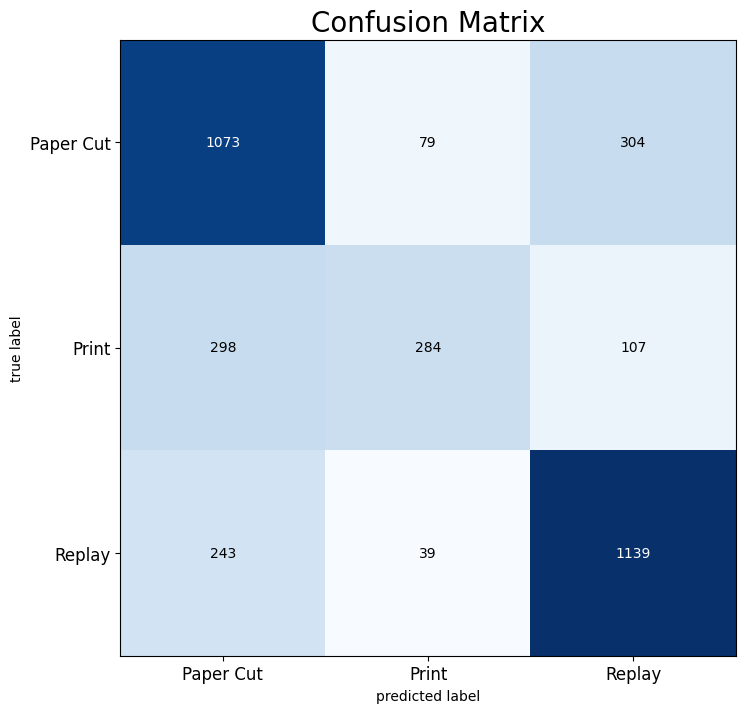



Outras métricas



{'spoof_1_print': 0, 'spoof_2_paper_cut': 1, 'spoof_3_replay': 2}
0
Precision     : 66.48%
Recall        : 73.70%
F1-Score      : 69.90%
1
Precision     : 70.65%
Recall        : 41.22%
F1-Score      : 52.06%
2
Precision     : 73.48%
Recall        : 80.15%
F1-Score      : 76.67%


In [ ]:
CM = confusion_matrix(y_trueC, y_predC)
classes =  ['Paper Cut','Print','Replay']

fig, ax = plot_confusion_matrix(conf_mat=CM ,  figsize=(10,8), hide_ticks=True,cmap=plt.cm.Blues)
plt.xticks(range(3), classes, fontsize=12)
plt.yticks(range(3), classes, fontsize=12)
plt.title("Confusion Matrix", fontsize=20)
plt.show()

precision = precision_score(y_trueC, y_predC, average=None)
recall = recall_score(y_trueC, y_predC, average=None)
f1 = f1_score(y_trueC, y_predC, average=None)
print("\n")
print("Outras métricas")
print("\n\n")
print(testgen.class_indices)
for i in range(0,3):
    print(i)
    print("%s%.2f%s"% ("Precision     : ", precision[i]*100, "%"))
    print("%s%.2f%s"% ("Recall        : ", recall[i]*100,    "%"))
    print("%s%.2f%s"% ("F1-Score      : ", f1[i]*100,        "%"))